In [12]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tifffile import imread, imsave
from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible

from stardist import random_label_cmap, _draw_polygons, export_imagej_rois
from stardist.models import StarDist2D

np.random.seed(6)
lbl_cmap = random_label_cmap()
from ipywidgets import interactive, interact
import os
import pandas as pd
from skimage.measure import regionprops_table
import seaborn as sns
from tqdm.notebook import tqdm
from skimage.transform import resize
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [8]:
model = StarDist2D(None, name='stardist_no_shape_completion', basedir='/home/georgeos/Storage/Google Drive (Cambridge Univeristy)/SYMPTOMM_models/bent_noisematched_allsize_empty_und6_unarelu_unlasigmoid_epc1000')


X = sorted(glob("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/extracted_long_trenches/*.tif"))
X = list(map(imread,X))

requires_resize = True
resize_shape = (256,64)
if requires_resize:
    #X = [resize(x,(32,8), order=0, mode='reflect', cval=0, clip=True, preserve_range=True, anti_aliasing=None, anti_aliasing_sigma=None) for x in tqdm(X)]
    X = [resize(x,resize_shape, order=0, mode='reflect', cval=0, clip=True, preserve_range=True, anti_aliasing=None, anti_aliasing_sigma=None) for x in tqdm(X)]

n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))




Loading network weights from 'weights_best.h5'.
Couldn't load thresholds from 'thresholds.json', using default values. (Call 'optimize_thresholds' to change that.)
Using default values: prob_thresh=0.5, nms_thresh=0.4.


  0%|          | 0/30825 [00:00<?, ?it/s]

In [10]:
names = sorted(os.listdir("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/extracted_long_trenches/"))

In [21]:
for z in tqdm(range(len(X))):
    img = normalize(X[z], 1,100, axis=axis_norm)
    labels, details = model.predict_instances(img, prob_thresh=0.8, nms_thresh=0.1)
    imsave(
        "/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/predictions_0.8/masks_resized/{}".format(names[z]),labels)
    imsave(
        "/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/predictions_0.8/images_resized/{}".format(names[z]),img)
    

  0%|          | 0/30825 [00:00<?, ?it/s]

## playing around

In [ ]:
all_labels_1 = []
all_details_1 = []
all_imgs_1 = []
for z in range(len(X)):
    img = normalize(X[z], 1,100, axis=axis_norm)
    labels, details = model.predict_instances(img, prob_thresh=0.7, nms_thresh=0.1)
    all_labels_1.append(labels)
    all_details_1.append(details)
    all_imgs_1.append(img)

@interact
def plotter_1(x=(0,len(X)-1)):
    plt.figure(figsize=(8,8))
    plt.imshow(all_imgs_1[x] if all_imgs_1[x].ndim==2 else all_imgs_1[x][...,0], clim=(0,1), cmap='gray')
    plt.imshow(all_labels_1[x], cmap=lbl_cmap, alpha=0.35)
    plt.axis('off');
    plt.show()
    plt.close()

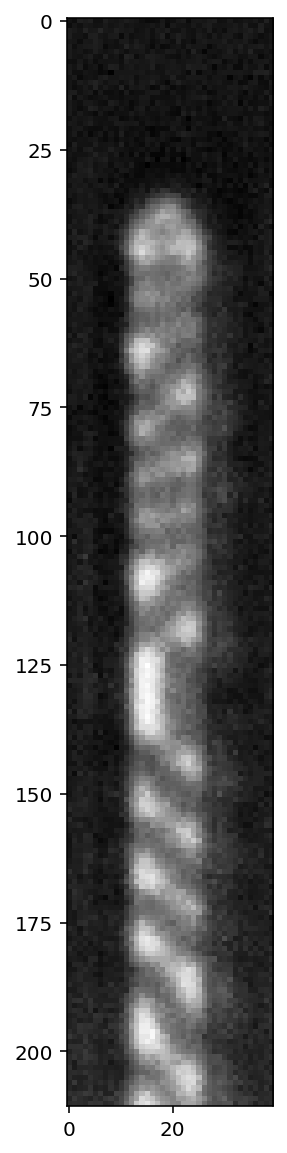

In [71]:
plt.figure(figsize=(10,10))
plt.imshow(resize(all_imgs_1[0],(211,40), order=0, mode='reflect', cval=0, clip=True, preserve_range=True, anti_aliasing=None, anti_aliasing_sigma=None),cmap="Greys_r")

In [3]:
from scipy.signal import find_peaks
from skimage.segmentation import clear_border

In [4]:
properties = ["area","centroid","major_axis_length","minor_axis_length"]

trenches = os.listdir("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/top_trenches_PC/")
trenches.sort()
model = StarDist2D(None, name='stardist_no_shape_completion', basedir='models_mixed_size_1600_epoch_good_50')
all_cell_data = pd.DataFrame()
master_label = []
master_imgs = []
exception_trenches = ["trench_52", "trench_54"]
for trench in tqdm(trenches):
    cell_data = pd.DataFrame()

    X = sorted(glob("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/top_trenches_PC/{}/*.tif".format(trench)))
    X = list(map(imread,X))

    n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
    axis_norm = (0,1)   # normalize channels independently
    # axis_norm = (0,1,2) # normalize channels jointly
    if n_channel > 1:
        print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))


    all_labels = []
    all_details = []
    all_imgs = []
    for z in range(3,25):
        img = normalize(X[z], 1,100, axis=axis_norm)
        if z == 3:
            if trench in exception_trenches:
                midpoint = int(img.shape[1]/2)
            else:
                image_profile = img.mean(axis=0)
                peaks = find_peaks(image_profile, height=np.mean(image_profile)*0.9)
                if len(peaks[0]) > 1:
                    midpoint = int(np.sum(peaks[0])/2)
                elif len(peaks[0]) == 1:
                    midpoint = peaks[0][0]
                trench_half_width = 15
        
        labels, details = model.predict_instances(img, prob_thresh=0.7, nms_thresh=0.1)
        

        labels = clear_border(labels[:,midpoint-trench_half_width:midpoint+trench_half_width])
        
        
        all_labels.append(labels)
        all_details.append(details)
        all_imgs.append(img[:,midpoint-trench_half_width:midpoint+trench_half_width])
        
    for label_image in all_labels:
        if len(np.unique(label_image)) > 1:
            cell_data = cell_data.append(pd.DataFrame(regionprops_table(label_image=label_image, properties=properties)).sort_values(by = "centroid-0").iloc[0])
        else:
            cell_data = cell_data.append(pd.Series([np.nan]*len(properties)),ignore_index=True)
    cell_data.reset_index(inplace=True,drop=True)
    cell_data["cell"] = trench
    cell_data["time"] = range(3,25)
    all_cell_data = all_cell_data.append(cell_data)
    all_cell_data.reset_index(inplace=True,drop=True)
    master_label.append(all_labels)
    master_imgs.append(all_imgs)

  0%|          | 0/56 [00:00<?, ?it/s]

Loading network weights from 'weights_best.h5'.
Couldn't load thresholds from 'thresholds.json', using default values. (Call 'optimize_thresholds' to change that.)
Using default values: prob_thresh=0.5, nms_thresh=0.4.


100%|██████████| 56/56 [01:13<00:00,  1.32s/it]


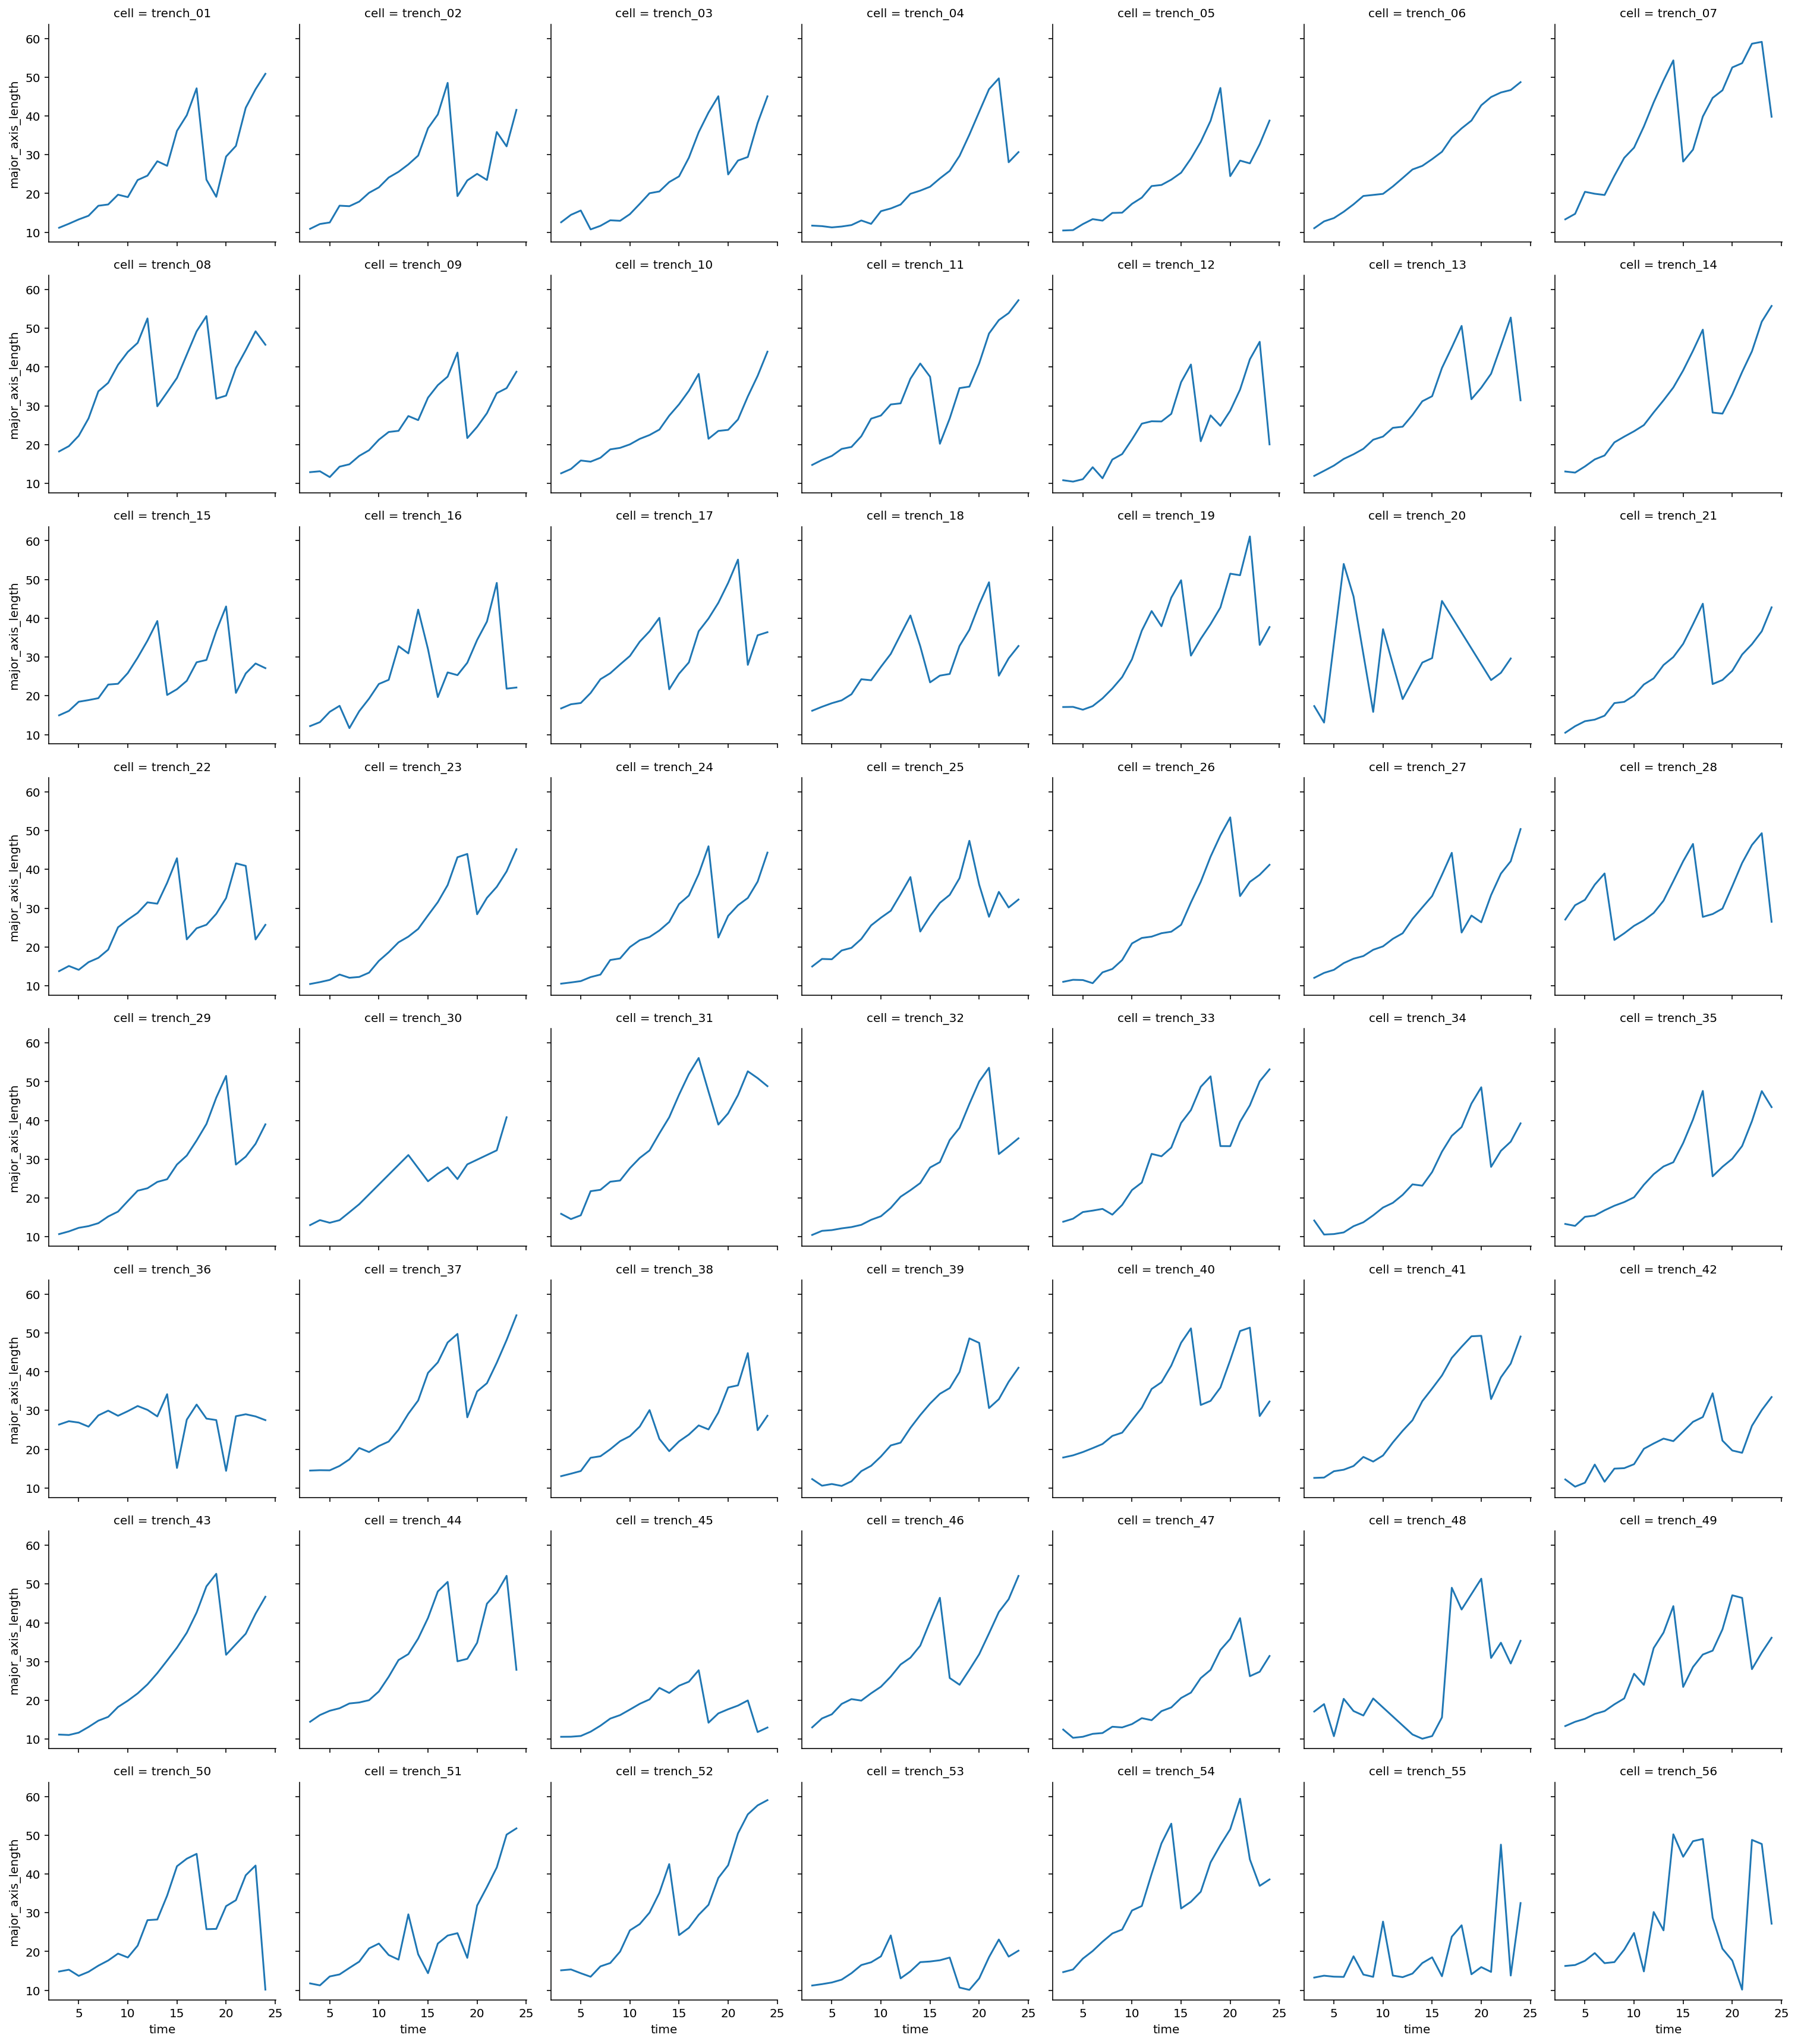

In [5]:
g = sns.FacetGrid(all_cell_data, col='cell', col_wrap=7)
g = g.map(sns.lineplot, 'time', 'major_axis_length', ci=None).add_legend()
plt.tight_layout()
plt.savefig("test_1600_epoch_50perc.pdf")

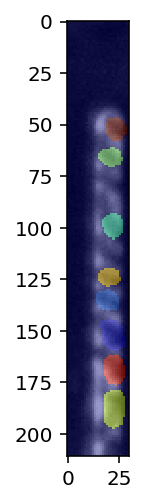

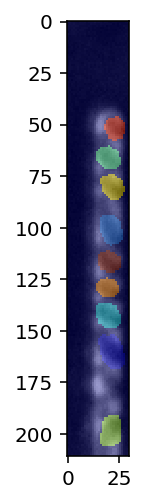

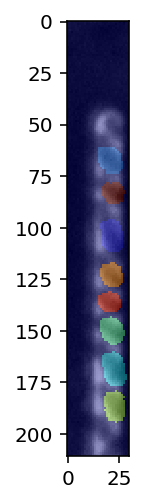

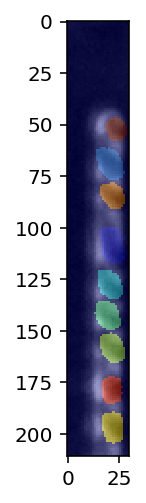

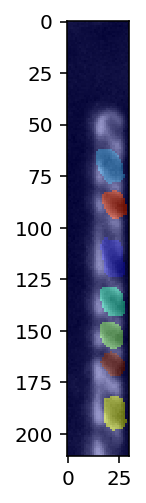

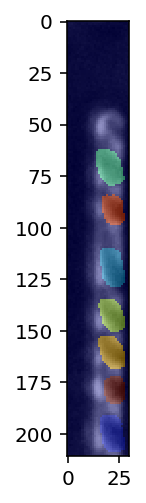

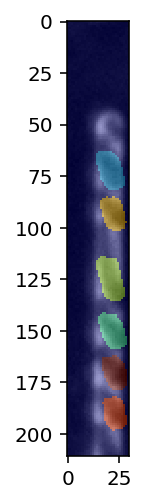

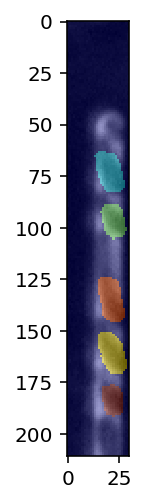

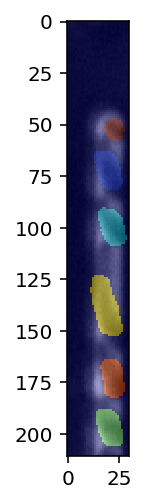

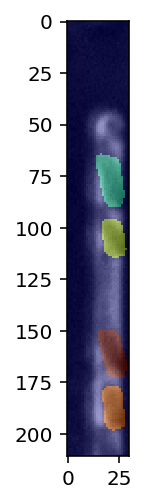

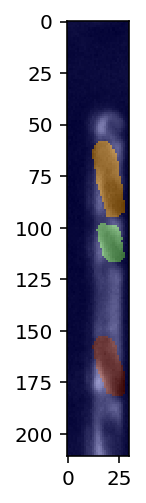

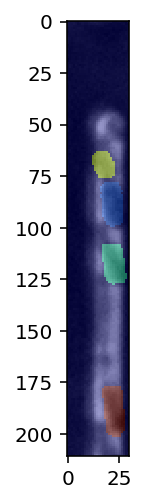

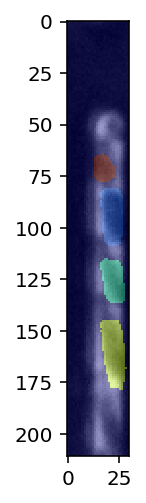

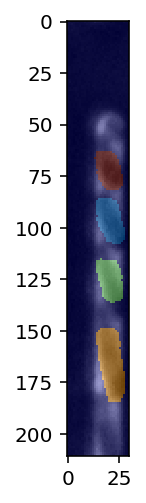

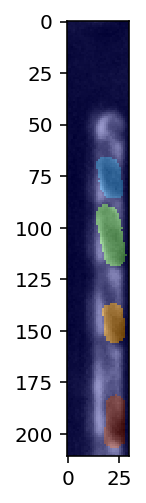

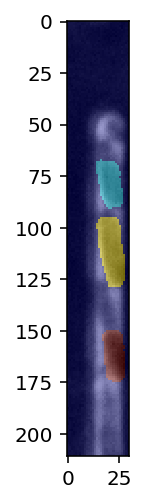

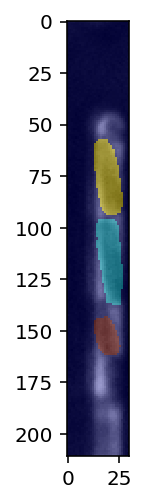

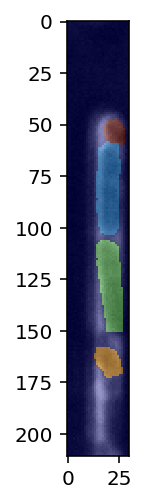

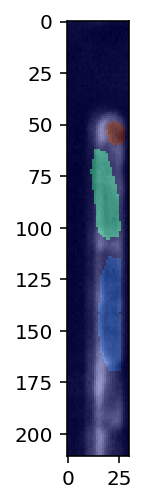

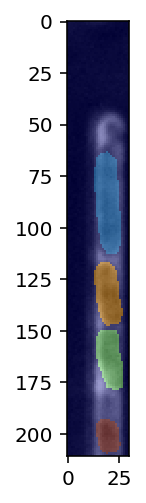

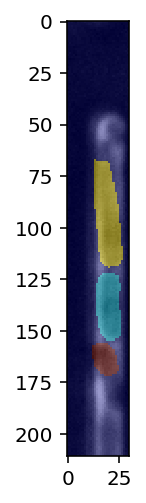

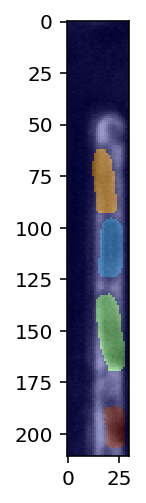

In [110]:
for x in range(len(master_imgs[0])):
    plt.imshow(master_imgs[54][x],cmap="Greys_r")
    plt.imshow(master_label[54][x],alpha=0.4,cmap="jet")
    plt.show()
    plt.close()

In [87]:
if False:
    fig, ax = plt.subplots(7,8, figsize=(16,16))
    for i,(a,x) in enumerate(zip(ax.flat, X)):
        a.imshow(x if x.ndim==2 else x[...,0], cmap='gray')
        a.set_title(i)
    [a.axis('off') for a in ax.flat]
    plt.tight_layout()
None;

In [72]:
all_labels = []
all_details = []
all_imgs = []
for z in range(25):
    img = normalize(X[z], 1,100, axis=axis_norm)
    labels, details = model.predict_instances(img, prob_thresh=0.6, nms_thresh=0.1)
    all_labels.append(labels)
    all_details.append(details)
    all_imgs.append(img)
    
@interact
def plotter(x=(0,len(X)-1)):
    plt.figure(figsize=(8,8))
    plt.imshow(all_imgs[x] if all_imgs[x].ndim==2 else all_imgs[x][...,0], clim=(0,1), cmap='gray')
    plt.imshow(all_labels[x], cmap=lbl_cmap, alpha=0.35)
    plt.axis('off');
    plt.show()
    plt.close()

interactive(children=(IntSlider(value=12, description='x', max=24), Output()), _dom_classes=('widget-interact'…

In [73]:
from skimage.measure import regionprops, regionprops_table
import pandas as pd

In [84]:
trenches = os.listdir("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/top_trenches_PC/")

In [75]:
a = 0
for t in range(len(trench))
cell_data = pd.DataFrame()
for label_image in all_labels:
    cell_data = cell_data.append(pd.DataFrame(regionprops_table(label_image=label_image, properties=properties)).sort_values(by = "centroid-0").iloc[0])
cell_data.reset_index(inplace=True,drop=True)
cell_data["cell"] = a

In [81]:
cell_data

,area,centroid-0,centroid-1,major_axis_length
0,211.0,62.843602,19.412322,24.033503
1,214.0,65.271028,19.607477,23.609496
2,224.0,67.424107,19.705357,24.542168
3,223.0,70.394619,19.408072,25.095504
4,86.0,53.511628,17.720930,12.268630
5,112.0,52.026786,18.017857,14.810434
6,174.0,53.931034,17.804598,19.331194
7,193.0,54.917098,18.984456,21.192400
8,184.0,56.260870,20.309783,20.717066
9,199.0,57.653266,20.603015,22.241794


In [11]:
model = StarDist2D(None, name='stardist_no_shape_completion', basedir='models_nohist')

trenches = os.listdir("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/top_trenches_PC/")
all_cell_data = pd.DataFrame()
for trench in trenches:
    cell_data = pd.DataFrame()

    X = sorted(glob("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/top_trenches_PC/{}/*.tif".format(trench)))
    X = list(map(imread,X))

    n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
    axis_norm = (0,1)   # normalize channels independently
    # axis_norm = (0,1,2) # normalize channels jointly
    if n_channel > 1:
        print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))


    all_labels = []
    all_details = []
    all_imgs = []
    for z in range(0,25):
        img = normalize(X[z], 1,100, axis=axis_norm)
        labels, details = model.predict_instances(img, prob_thresh=0.7, nms_thresh=0.1)
        all_labels.append(labels)
        all_details.append(details)
        all_imgs.append(img)
        
    for label_image in all_labels:
        cell_data = cell_data.append(pd.DataFrame(regionprops_table(label_image=label_image, properties=properties)).sort_values(by = "centroid-0").iloc[0])
    cell_data.reset_index(inplace=True,drop=True)
    cell_data["cell"] = trench
    cell_data["time"] = range(0,25)
    all_cell_data = all_cell_data.append(cell_data)
    all_cell_data.reset_index(inplace=True,drop=True)
    print(trench)


Loading network weights from 'weights_best.h5'.
Couldn't load thresholds from 'thresholds.json', using default values. (Call 'optimize_thresholds' to change that.)
Using default values: prob_thresh=0.5, nms_thresh=0.4.
trench_01
trench_02
trench_03
trench_04
trench_05
trench_06
trench_07
trench_08
trench_09
trench_10
trench_56
trench_55
trench_54
trench_53
trench_52
trench_51
trench_50
trench_49
trench_48
trench_47
trench_46
trench_45
trench_44
trench_43
trench_42
trench_41
trench_40
trench_39
trench_38
trench_37
trench_36
trench_35
trench_34
trench_33
trench_32
trench_31
trench_30
trench_29
trench_28
trench_27
trench_26
trench_25
trench_24
trench_23
trench_22
trench_21
trench_20
trench_19
trench_18
trench_17
trench_16
trench_15
trench_14
trench_13
trench_12
trench_11


In [47]:
all_cell_data["minor_axis_length"] = (all_cell_data["minor_axis_length"])*2.5

In [48]:
all_cell_data_temp = pd.melt(all_cell_data,value_vars=["major_axis_length","minor_axis_length"],id_vars =["centroid-0","centroid-1","cell","time"])

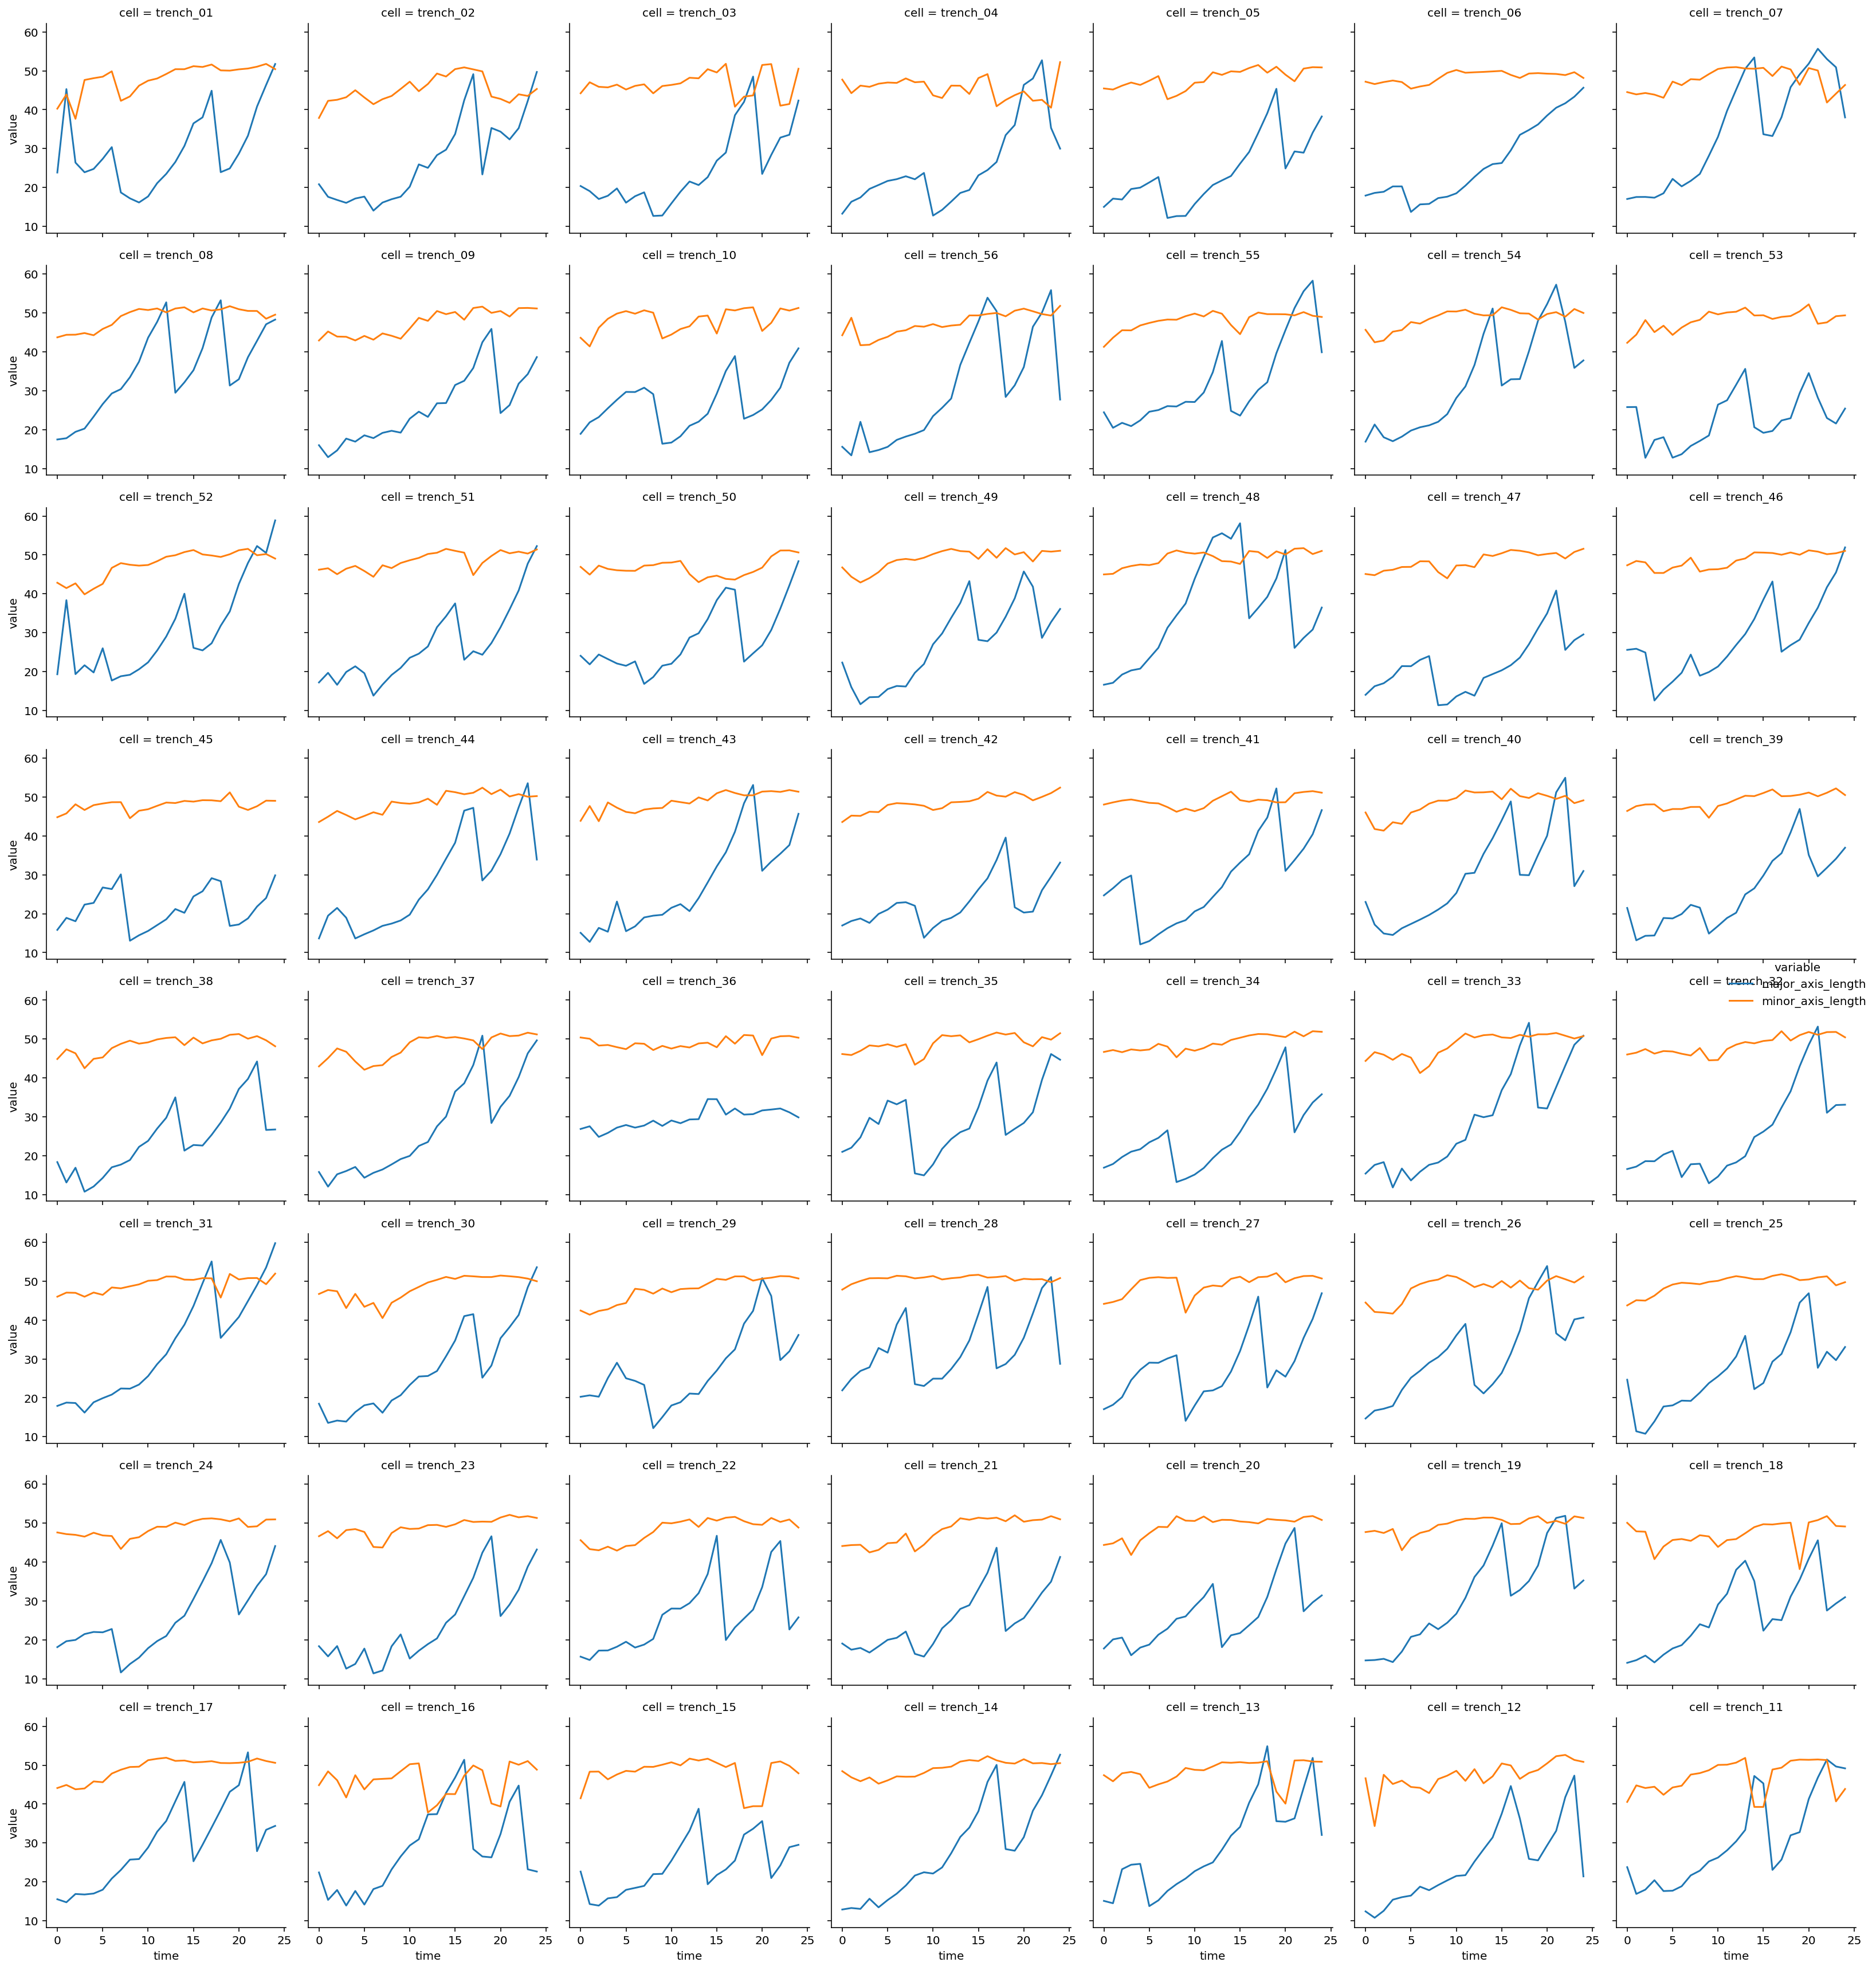

In [49]:
g = sns.FacetGrid(all_cell_data_temp, col='cell', hue="variable",col_wrap=7)
g = g.map(sns.lineplot, 'time', "value", ci=None).add_legend()
plt.tight_layout()
plt.savefig("test_nohist.pdf",dpi=200)

Loading network weights from 'weights_best.h5'.
Couldn't load thresholds from 'thresholds.json', using default values. (Call 'optimize_thresholds' to change that.)
Using default values: prob_thresh=0.5, nms_thresh=0.4.
trench_01
trench_02
trench_03
trench_04
trench_05
trench_06
trench_07
trench_08
trench_09
trench_10
trench_56
trench_55
trench_54
trench_53
trench_52
trench_51
trench_50
trench_49
trench_48
trench_47
trench_46
trench_45
trench_44
trench_43
trench_42
trench_41
trench_40
trench_39
trench_38
trench_37
trench_36
trench_35
trench_34
trench_33
trench_32
trench_31
trench_30
trench_29
trench_28
trench_27
trench_26
trench_25
trench_24
trench_23
trench_22
trench_21
trench_20
trench_19
trench_18
trench_17
trench_16
trench_15
trench_14
trench_13
trench_12
trench_11


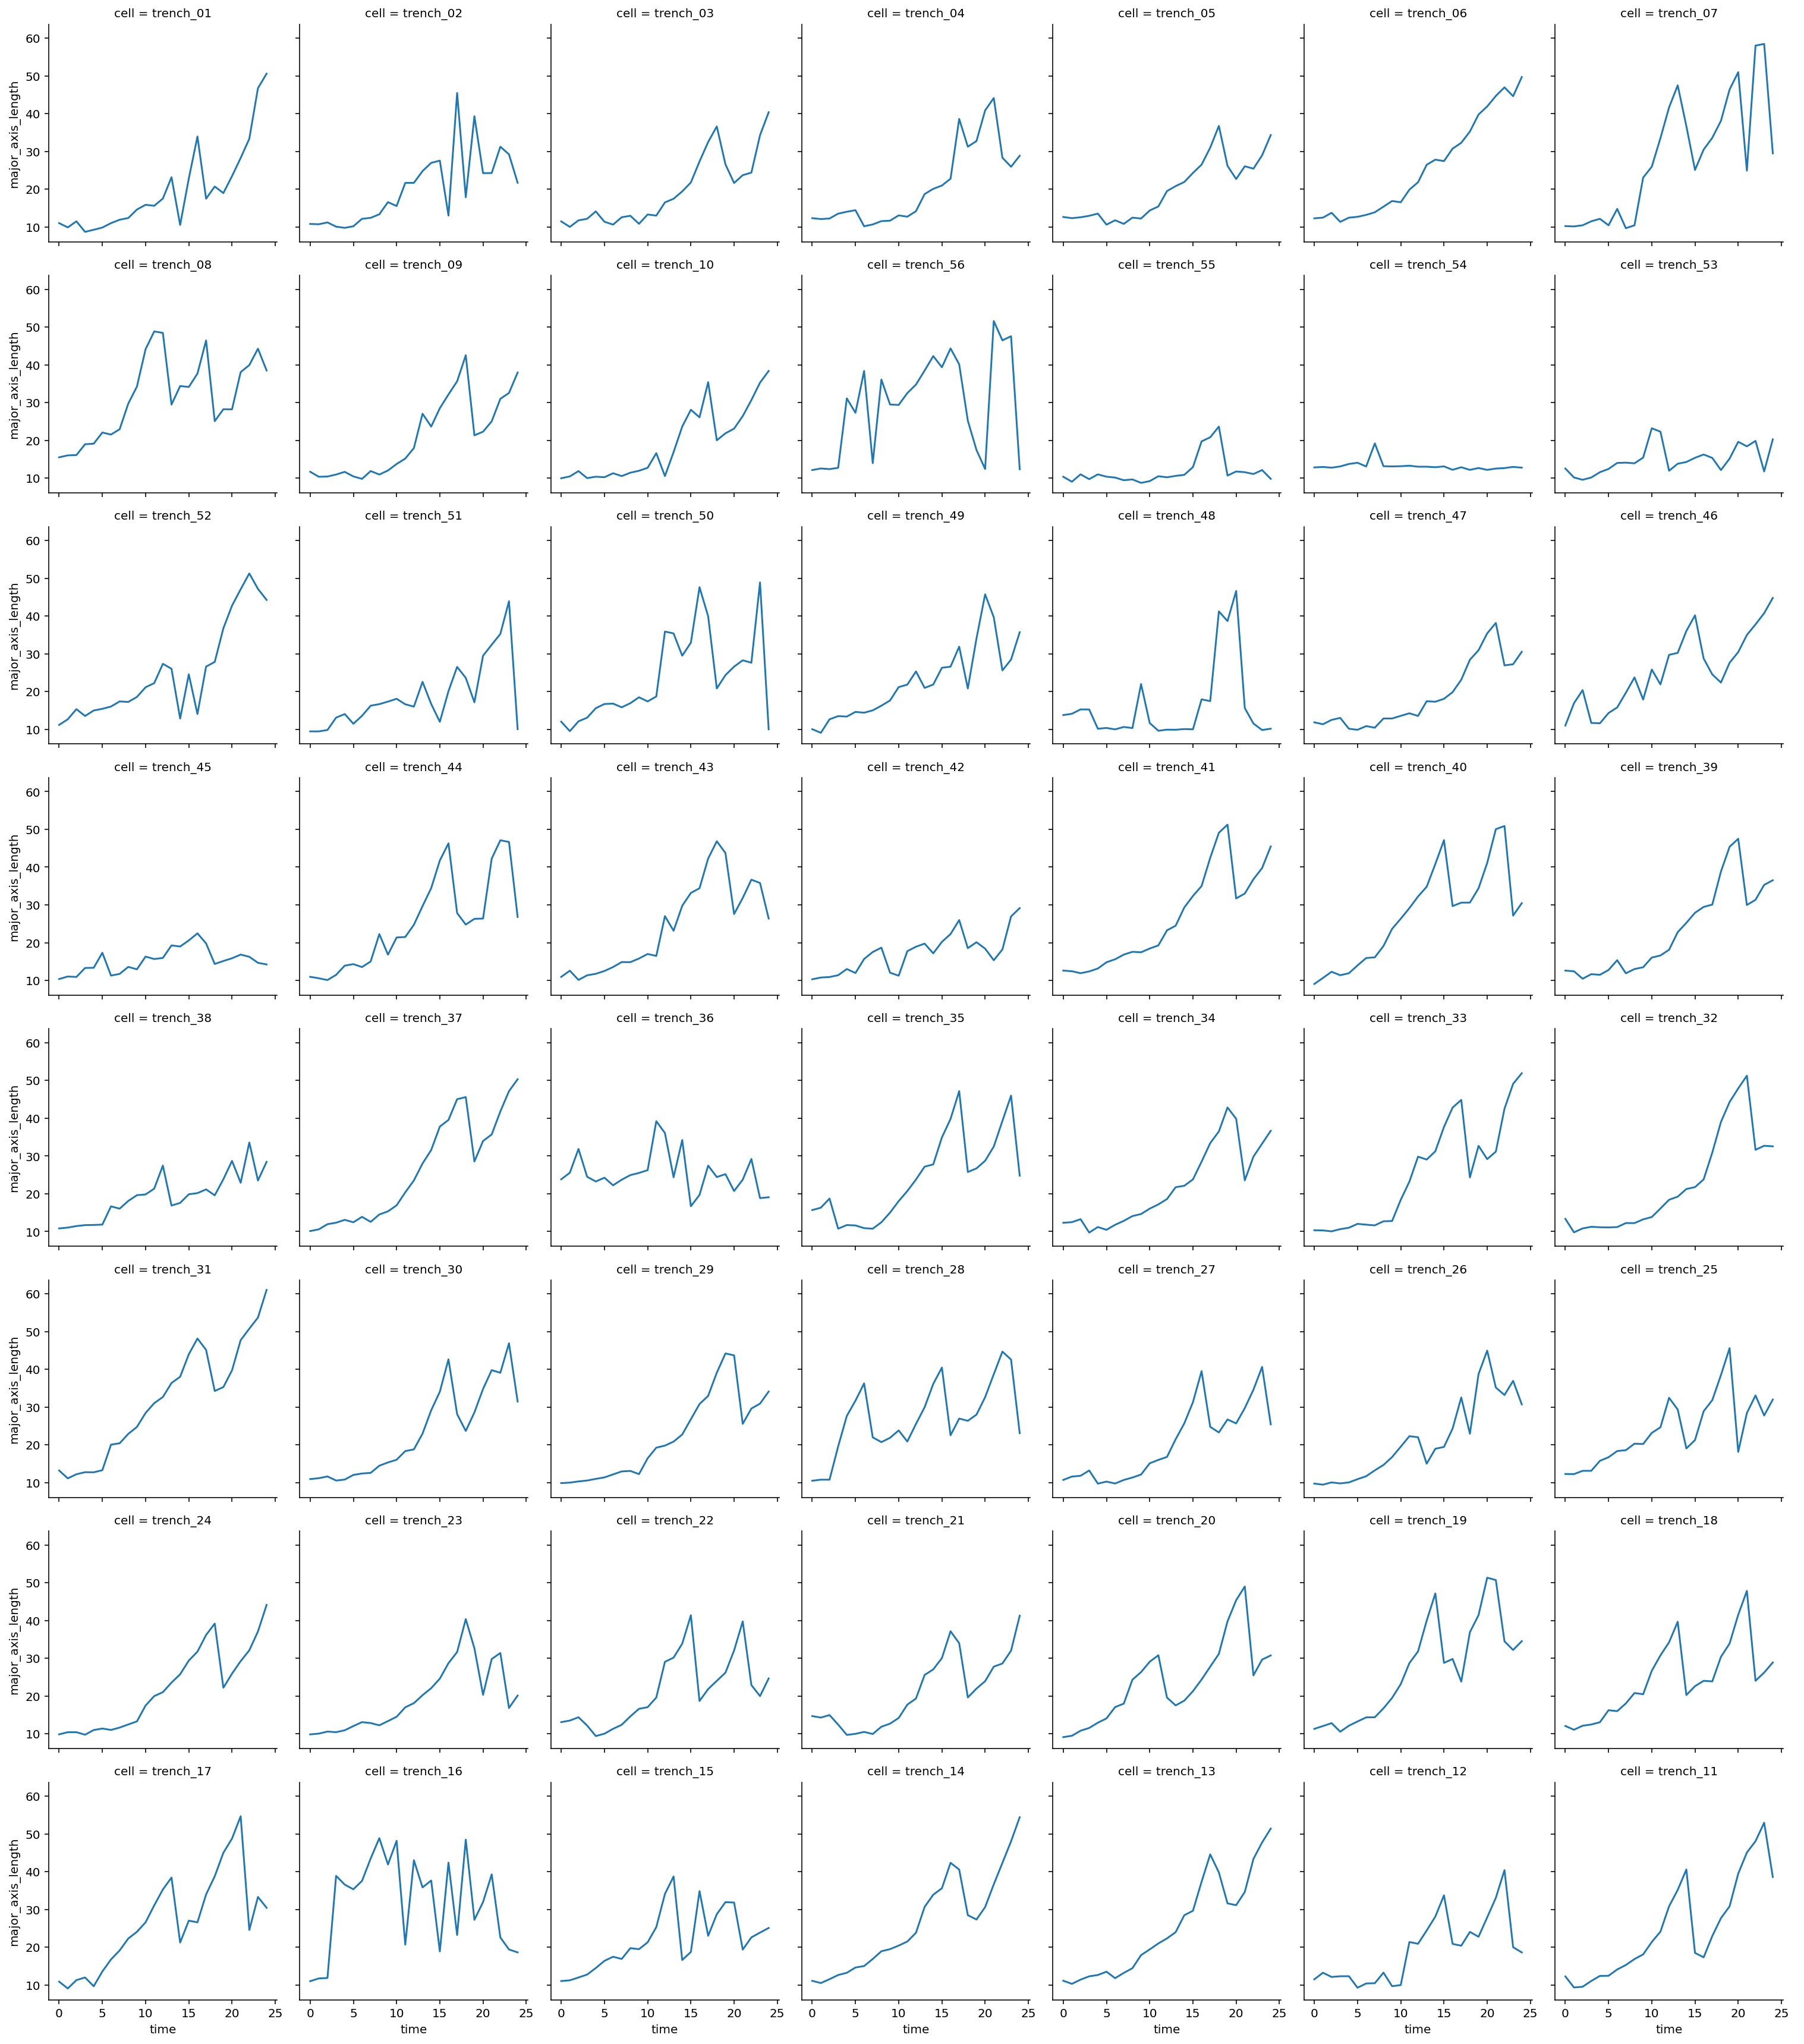

In [6]:
model = StarDist2D(None, name='stardist_no_shape_completion', basedir='models')

trenches = os.listdir("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/top_trenches_PC/")
all_cell_data = pd.DataFrame()
for trench in trenches:
    cell_data = pd.DataFrame()

    X = sorted(glob("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/top_trenches_PC/{}/*.tif".format(trench)))
    X = list(map(imread,X))

    n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
    axis_norm = (0,1)   # normalize channels independently
    # axis_norm = (0,1,2) # normalize channels jointly
    if n_channel > 1:
        print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))


    all_labels = []
    all_details = []
    all_imgs = []
    for z in range(0,25):
        img = normalize(X[z], 1,100, axis=axis_norm)
        labels, details = model.predict_instances(img, prob_thresh=0.65, nms_thresh=0.1)
        all_labels.append(labels)
        all_details.append(details)
        all_imgs.append(img)
        
    for label_image in all_labels:
        cell_data = cell_data.append(pd.DataFrame(regionprops_table(label_image=label_image, properties=properties)).sort_values(by = "centroid-0").iloc[0])
    cell_data.reset_index(inplace=True,drop=True)
    cell_data["cell"] = trench
    cell_data["time"] = range(0,25)
    all_cell_data = all_cell_data.append(cell_data)
    all_cell_data.reset_index(inplace=True,drop=True)
    print(trench)
g = sns.FacetGrid(all_cell_data, col='cell', col_wrap=7)
g = g.map(sns.lineplot, 'time', 'major_axis_length', ci=None).add_legend()
plt.tight_layout()
plt.savefig("test_mixed_cells.png",dpi=200)

In [35]:
all_labels_1 = []
all_details_1 = []
all_imgs_1 = []
for z in range(25):
    img = normalize(X[z], 1,100, axis=axis_norm)
    labels, details = model.predict_instances(img, prob_thresh=0.6, nms_thresh=0.1)
    all_labels_1.append(labels)
    all_details_1.append(details)
    all_imgs_1.append(img)
    
@interact
def plotter_1(x=(0,len(X)-1)):
    plt.figure(figsize=(8,8))
    plt.imshow(all_imgs_1[x] if all_imgs[x].ndim==2 else all_imgs_1[x][...,0], clim=(0,1), cmap='gray')
    plt.imshow(all_labels_1[x], cmap=lbl_cmap, alpha=0.35)
    plt.axis('off');
    plt.show()
    plt.close()

interactive(children=(IntSlider(value=12, description='x', max=24), Output()), _dom_classes=('widget-interact'…